# Check dragon nodes on PANDA

In this notebook we will use the TFs that were found to have "differential" correlation between the CMS2 and CMS4
subtypes to interrogate the PANDA networks.

First we will define some common filenames and functions.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

# import all functions from utils.py that is inside src folder
from src.utils import *


Mapping of genes with the gencode names

In [2]:
# we need to map TF names and symbols to ensembl IDs
ens2sym, sym2ens = get_gencode_maps(gencode_fn = "../data/external/gen_v26_mapping.csv")

We read the PANDA networks. Here we are only focusing on CMS2 and CMS4

In [3]:
panda_fn  = {#'cms1':'../data/processed/batch-coad-subtype-20240510/tcga_coad_cms1/analysis/panda/panda_tcga_coad_cms1.txt',
             'cms2': '../data/processed/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/panda/panda_tcga_coad_cms2.txt',
             #'cms3': '../data/processed/batch-coad-subtype-20240510/tcga_coad_cms3/analysis/panda/panda_tcga_coad_cms3.txt',
             'cms4': '../data/processed/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/panda/panda_tcga_coad_cms4.txt'}

In [4]:
# read PANDA
pandas = read_pandas(panda_fn)

cms2
cms4


In [5]:
# we need to keep track of the TF names for later, and we are going to check those that are common between CMS2 and CMS4
tf_pandas_shared = set(pandas['cms2'].index.tolist()).intersection(set(pandas['cms4'].index.tolist()))

We need the cluster names generated by the `colon_subtype_dragons` notebook. We provide them alongside the code. 

In [6]:
clusters = {'cluster_A':'../results/cms-post/all_cms_dragon_clustA.csv',
            'cluster_D':'../results/cms-post/all_cms_dragon_clustD.csv',}

Specify output folder: if the folder doesn't exist it is created

In [7]:
output_folder = '../results/cms-post/'
# make folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
else:
    print('Folder exists')

Folder exists


Here we will choose a cluster (A or D)

In [28]:
# Specify which cluster we are going to use (either cluster A or D)
cluster_name = 'cluster_D'

In [29]:

# Files will be saved in a subfolder with the cluster name
panda_folder = output_folder + cluster_name + '_panda/'
if not os.path.exists(panda_folder):
    os.makedirs(panda_folder)

# Read the cluster file and get the TFs of interest
ca = pd.read_csv(clusters[cluster_name], index_col=0)
# The table keeps all edges from the TF of interest, then we have to subselect only the edges of interest
tf_ca = set(ca[ca['oi']==True]['node1_tf'].tolist() + ca[ca['oi']==True]['node2_tf'].tolist())
# These would be the TFs for which we have looked into the expression
tf_expression = set(ca[ca['oi']==True]['node2_tf'].tolist())


## If we want to use all tf of interest in the two clusters
#ca = pd.read_csv(clusters['cluster_A'], index_col=0)
#cd = pd.read_csv(clusters['cluster_D'], index_col=0)
#tf_ca = set(ca[ca['oi']==True]['node1_tf'].tolist() + ca[ca['oi']==True]['node2_tf'].tolist())
#tf_cd = set(cd[cd['oi']==True]['node1_tf'].tolist() + cd[cd['oi']==True]['node2_tf'].tolist())
# tf_ca = tf_ca.union(tf_cd)

## Check PANDA network for TFs of interest

We have extracted the TFs of interest for the cluster specified, now we check what targets of TFs have undergone the
biggest changes between the two subtypes

In [30]:
# get only edges for tf from dragon
cms2_dragon = pandas['cms2'].loc[list(set(tf_pandas_shared).intersection(tf_ca)),:].melt(ignore_index = False, var_name = 'ens', value_name = 'cms2').reset_index()
cms4_dragon = pandas['cms4'].loc[list(set(tf_pandas_shared).intersection(tf_ca)),:].melt(ignore_index = False, var_name = 'ens', value_name = 'cms4').reset_index()

# Get long table for values
values_cms = cms2_dragon.merge(cms4_dragon, on = ['tf', 'ens'], how = 'inner')

values_cms 

In [ ]:
# Get difference between the actual PANDA edge values
values_cms['value_cms2_cms4'] = values_cms['cms2'] - values_cms['cms4']
values_cms['value_cms2_cms4_abs'] = np.abs(values_cms['value_cms2_cms4'])
values_cms.head()

,tf,ens,cms2,cms4,value_cms2_cms4,value_cms2_cms4_abs
0,GATA6,ENSG00000000003,0.371709,0.058794,0.312915,0.312915
1,FOXD1,ENSG00000000003,0.625221,0.265443,0.359778,0.359778
2,ZNF274,ENSG00000000003,-0.148254,-0.359470,0.211216,0.211216
3,NR1I3,ENSG00000000003,-0.008196,-0.146343,0.138147,0.138147
4,THRB,ENSG00000000003,-1.032867,-0.887099,-0.145768,0.145768


In [ ]:
# Get long table for ranks (for each tf rank the genes)
# We do the same as before but we compare ranks, instead of actual values
rank_cms2 = pandas['cms2'].loc[list(set(tf_pandas_shared).intersection(tf_ca)),:].rank(axis = 1).melt(ignore_index = False, var_name = 'ens', value_name = 'rank_cms2').reset_index()
rank_cms4 = pandas['cms4'].loc[list(set(tf_pandas_shared).intersection(tf_ca)),:].rank(axis = 1).melt(ignore_index = False, var_name = 'ens', value_name = 'rank_cms4').reset_index()
# we aenk the values and differences
rank_cms = rank_cms2.merge(rank_cms4, on = ['tf', 'ens'], how = 'inner')
rank_cms['rank_cms2_cms4'] = rank_cms['rank_cms2'] - rank_cms['rank_cms4']
rank_cms['rank_cms2_cms4_abs'] = np.abs(rank_cms['rank_cms2_cms4'])
rank_cms.head()

,tf,ens,rank_cms2,rank_cms4,rank_cms2_cms4,rank_cms2_cms4_abs
0,GATA6,ENSG00000000003,14539.0,12016.0,2523.0,2523.0
1,FOXD1,ENSG00000000003,13380.0,11593.0,1787.0,1787.0
2,ZNF274,ENSG00000000003,12338.0,10544.0,1794.0,1794.0
3,NR1I3,ENSG00000000003,13773.0,11906.0,1867.0,1867.0
4,THRB,ENSG00000000003,2755.0,5019.0,-2264.0,2264.0


In [ ]:
# merge the two tables
panda_rank = rank_cms.merge(values_cms, on = ['tf', 'ens'])
panda_rank['symbol'] = panda_rank['ens'].map(ens2sym)
panda_rank.sort_values('value_cms2_cms4_abs', ascending = False)

,tf,ens,rank_cms2,rank_cms4,rank_cms2_cms4,rank_cms2_cms4_abs,cms2,cms4,value_cms2_cms4,value_cms2_cms4_abs,symbol
340850,HOXA3,ENSG00000225315,14314.0,4166.0,10148.0,10148.0,1.534973,-2.546409,4.081382e+00,4.081382e+00,RP11-293P20.2
340855,POU2F3,ENSG00000225315,19583.0,15004.0,4579.0,4579.0,5.268483,1.481077,3.787406e+00,3.787406e+00,RP11-293P20.2
448398,HOXA3,ENSG00000281383,3581.0,12562.0,-8981.0,8981.0,-2.667444,1.041533,-3.708977e+00,3.708977e+00,CH507-513H4.5
340842,FOXJ2,ENSG00000225315,12734.0,3995.0,8739.0,8739.0,1.302393,-2.345242,3.647634e+00,3.647634e+00,RP11-293P20.2
340854,FOXJ1,ENSG00000225315,18968.0,11955.0,7013.0,7013.0,4.651830,1.029829,3.622002e+00,3.622002e+00,RP11-293P20.2
...,...,...,...,...,...,...,...,...,...,...,...
329515,FOXJ1,ENSG00000214558,11973.0,12407.0,-434.0,434.0,1.131113,1.131110,2.445627e-06,2.445627e-06,RP11-74E24.2
26319,YY2,ENSG00000074706,348.0,322.0,26.0,26.0,-1.385259,-1.385258,-1.623747e-06,1.623747e-06,IPCEF1
11059,FOXA1,ENSG00000037280,5617.0,5524.0,93.0,93.0,-1.945295,-1.945294,-1.435298e-06,1.435298e-06,FLT4
325944,PROX2,ENSG00000213707,6533.0,6687.0,-154.0,154.0,-0.886755,-0.886754,-9.347164e-07,9.347164e-07,HMGB1P10


##### Select targets that vary a lot in value and in rank

For each TF, we have edges towards all targets. We are interested in finding the targets of the tfs of interest that
change "probability" of connection a lot between CMS2 and CMS4.
1. We assume that a gene is a TF target in that PANDA
network if its edge has value > 1, ence we select only edges that have values larger than 1 in either CMS2 or CMS4.
2. Out of these targets, we select those for which the ranking between CMS2 and CMS4 is high (we'll check below the
   percentile thresholds)
3. We also select the targets for which there is a difference of at least 1 between CMS2 and CMS4

967.0 1922.0


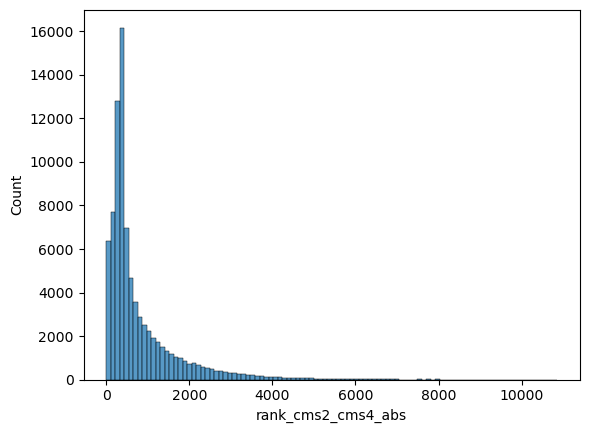

In [ ]:
temp0 = panda_rank[((panda_rank['cms2']>1) | (panda_rank['cms4']>1))]
#sns.histplot(temp0['value_cms2_cms4_abs'], bins = 100)
sns.histplot(temp0['rank_cms2_cms4_abs'], bins = 100)
print(np.percentile(temp0['rank_cms2_cms4_abs'], 75), np.percentile(temp0['rank_cms2_cms4_abs'], 90))

Around 1000 is the 75th percentile for the differences between two edges, while around 2000 is the 90th percentile.   
That is less than 25% of edges change their rank of more than 1000 positions, in either directions

Now we are gonna get edges that: 
- Have a difference in ranking of more than 1000 (or 2000)
- Are weighted at least 1 in either cms2 or cms4 (we ignore changes of edges that are not really plausible)
- Have a difference in absolute value between cms2 and cms4 of more than 1

In [ ]:
th = 1000
temp = panda_rank[(panda_rank['value_cms2_cms4_abs']>1) & (panda_rank['rank_cms2_cms4_abs']>th) & ((panda_rank['cms2']>1) | (panda_rank['cms4']>1))].sort_values('rank_cms2_cms4_abs', ascending = False)
temp

,tf,ens,rank_cms2,rank_cms4,rank_cms2_cms4,rank_cms2_cms4_abs,cms2,cms4,value_cms2_cms4,value_cms2_cms4_abs,symbol
340857,MEOX2,ENSG00000225315,14215.0,3360.0,10855.0,10855.0,1.103369,-2.288557,3.391926,3.391926,RP11-293P20.2
340850,HOXA3,ENSG00000225315,14314.0,4166.0,10148.0,10148.0,1.534973,-2.546409,4.081382,4.081382,RP11-293P20.2
340856,FOXA1,ENSG00000225315,14044.0,3986.0,10058.0,10058.0,1.159921,-2.228002,3.387923,3.387923,RP11-293P20.2
447991,MEOX2,ENSG00000280832,6040.0,15291.0,-9251.0,9251.0,-1.775200,1.252996,-3.028197,3.028197,ST3GAL4-AS1
448403,POU2F3,ENSG00000281383,4294.0,13484.0,-9190.0,9190.0,-2.282616,1.172703,-3.455319,3.455319,CH507-513H4.5
...,...,...,...,...,...,...,...,...,...,...,...
248096,POU2F3,ENSG00000172965,17571.0,18579.0,-1008.0,1008.0,3.121456,4.306172,-1.184716,1.184716,MIR4435-2HG
249494,HOXA3,ENSG00000173372,17079.0,18083.0,-1004.0,1004.0,2.857403,4.062901,-1.205498,1.205498,C1QA
37255,POU2F3,ENSG00000089199,18361.0,17358.0,1003.0,1003.0,4.380840,2.002611,2.378229,2.378229,CHGB
274038,LCORL,ENSG00000182648,17447.0,18448.0,-1001.0,1001.0,1.389872,2.901127,-1.511255,1.511255,LINC01006


In [ ]:
temp['edge'] = temp.tf + '-' + temp.symbol
temp

,tf,ens,rank_cms2,rank_cms4,rank_cms2_cms4,rank_cms2_cms4_abs,cms2,cms4,value_cms2_cms4,value_cms2_cms4_abs,symbol,edge
340857,MEOX2,ENSG00000225315,14215.0,3360.0,10855.0,10855.0,1.103369,-2.288557,3.391926,3.391926,RP11-293P20.2,MEOX2-RP11-293P20.2
340850,HOXA3,ENSG00000225315,14314.0,4166.0,10148.0,10148.0,1.534973,-2.546409,4.081382,4.081382,RP11-293P20.2,HOXA3-RP11-293P20.2
340856,FOXA1,ENSG00000225315,14044.0,3986.0,10058.0,10058.0,1.159921,-2.228002,3.387923,3.387923,RP11-293P20.2,FOXA1-RP11-293P20.2
447991,MEOX2,ENSG00000280832,6040.0,15291.0,-9251.0,9251.0,-1.775200,1.252996,-3.028197,3.028197,ST3GAL4-AS1,MEOX2-ST3GAL4-AS1
448403,POU2F3,ENSG00000281383,4294.0,13484.0,-9190.0,9190.0,-2.282616,1.172703,-3.455319,3.455319,CH507-513H4.5,POU2F3-CH507-513H4.5
...,...,...,...,...,...,...,...,...,...,...,...,...
248096,POU2F3,ENSG00000172965,17571.0,18579.0,-1008.0,1008.0,3.121456,4.306172,-1.184716,1.184716,MIR4435-2HG,POU2F3-MIR4435-2HG
249494,HOXA3,ENSG00000173372,17079.0,18083.0,-1004.0,1004.0,2.857403,4.062901,-1.205498,1.205498,C1QA,HOXA3-C1QA
37255,POU2F3,ENSG00000089199,18361.0,17358.0,1003.0,1003.0,4.380840,2.002611,2.378229,2.378229,CHGB,POU2F3-CHGB
274038,LCORL,ENSG00000182648,17447.0,18448.0,-1001.0,1001.0,1.389872,2.901127,-1.511255,1.511255,LINC01006,LCORL-LINC01006


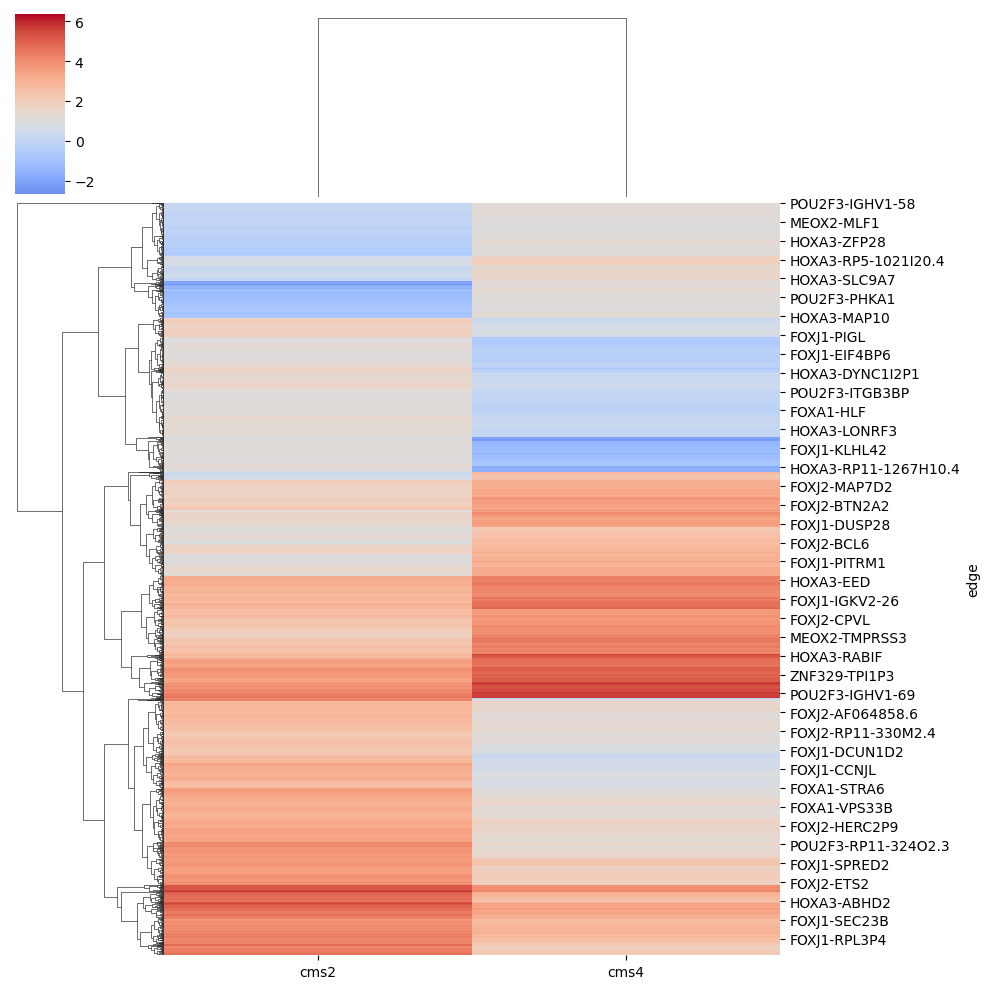

In [ ]:
# edges with high rank difference
sns.clustermap(temp.loc[:,['edge','cms2','cms4']].set_index('edge'), cmap = 'coolwarm', center = 1)

However it is hard to understand what we are looking at. There are many edges and we don't know what they do. 
We will proceed with a pathway analysis on the genes, such that we can see the targets of interest what pathways are
involved in

### Check what pathways these genes are involved with

In [ ]:
# pathway analysis of the genes involved , background is all the genes in the pandas
import gseapy as gp
gene_list = temp.symbol.unique().tolist()
print(len(gene_list))
bckg = panda_rank.symbol.unique().tolist()
res_reactome = gp.enrich(gene_list = gene_list, gene_sets='../data/external/reactome_slim/hugo_reactome_slim.gmt', background = bckg)


1326


In [ ]:
# save table
res_reactome.results.sort_values('Adjusted P-value').to_csv(panda_folder + 'reactome_enrichment.csv')

In [ ]:
# show table here
res_reactome.results.sort_values('Adjusted P-value')[res_reactome.results['Adjusted P-value']<0.05]

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_50618/1392000711.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_reactome.results.sort_values('Adjusted P-value')[res_reactome.results['Adjusted P-value']<0.05]


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
254,hugo_reactome_slim.gmt,Leishmania phagocytosis,26/129,4.215699e-07,0.000236,3.582868,52.593917,IGHV3-7;ELMO2;CYFIP2;CD247;IGKV2-30;CYFIP1;IGK...
163,hugo_reactome_slim.gmt,Fcgamma receptor (FCGR) dependent phagocytosis,27/156,5.595846e-06,0.000825,2.969623,35.913094,IGHV3-7;ELMO2;CYFIP2;CD247;IGKV2-30;CYFIP1;IGK...
84,hugo_reactome_slim.gmt,Creation of C4 and C2 activators,18/81,5.896201e-06,0.000825,4.060817,48.897116,IGKV1-39;IGHV3-7;IGKV4-1;C1QA;IGLV3-16;IGLV3-2...
61,hugo_reactome_slim.gmt,Cell surface interactions at the vascular wall,30/182,4.831811e-06,0.000825,2.799769,34.269977,IGHV3-7;CEACAM1;IGKV2-30;SIRPG;IGKV2D-30;IGKV1...
42,hugo_reactome_slim.gmt,Binding and Uptake of Ligands by Scavenger Rec...,20/102,1.362442e-05,0.001272,3.465189,38.822756,IGHV3-7;APOL1;IGKV2-30;IGKV2D-30;IGKV1-39;IGKV...
81,hugo_reactome_slim.gmt,Complement cascade,21/110,1.289219e-05,0.001272,3.351260,37.731464,IGHV3-7;C1QA;IGKV2-30;CD19;IGKV2D-30;IGKV1-39;...
218,hugo_reactome_slim.gmt,Initial triggering of complement,18/89,2.337344e-05,0.001870,3.604878,38.442093,IGKV1-39;IGHV3-7;IGKV4-1;C1QA;IGLV3-16;IGLV3-2...
24,hugo_reactome_slim.gmt,Anti-inflammatory response favouring Leishmani...,22/137,1.270912e-04,0.008896,2.715849,24.362807,IGHV3-7;CD247;PLK2;IGKV2-30;IGKV2D-30;IGKV1-39...
481,hugo_reactome_slim.gmt,Signaling by the B Cell Receptor (BCR),25/167,1.456561e-04,0.009063,2.496807,22.057450,IGHV3-7;IGKV2-30;CD22;CD19;IGKV2D-30;PSME2;IGK...


In [ ]:
# same analysis forKEGG pathjways
res = gp.enrich(gene_list = gene_list, gene_sets=['KEGG_2021_Human'], background = bckg)
res.results.sort_values('Adjusted P-value').to_csv(panda_folder + 'kegg_enrichment.csv')

In [ ]:
res.results.sort_values(by = 'Adjusted P-value').head(15)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Pathways in cancer,0.000748,0.142307,0,0,1.711453,12.319363,CDKN1A;CSF3R;WNT2B;HDAC1;MGST3;LEF1;TGFA;CSF2R...
1,KEGG_2021_Human,Transcriptional misregulation in cancer,0.000978,0.142307,0,0,2.302797,15.958257,CDKN1A;ITGAM;BCL11B;DEFA6;GADD45A;HDAC1;MMP3;P...
17,KEGG_2021_Human,Linoleic acid metabolism,0.015512,0.250779,0,0,5.030945,20.959592,CYP2J2;PLA2G2D;PLA2G4C;PLB1
16,KEGG_2021_Human,Fatty acid biosynthesis,0.015512,0.250779,0,0,5.030945,20.959592,MECR;ACSL6;ACSL5;ACACB
15,KEGG_2021_Human,PPAR signaling pathway,0.015162,0.250779,0,0,2.545488,10.662974,CPT2;MMP1;ME1;ACSL6;ACSL5;LPL;HMGCS2;SLC27A2;P...
14,KEGG_2021_Human,Endometrial cancer,0.013600,0.250779,0,0,2.598662,11.168201,CDKN1A;CDH1;GADD45A;MYC;LEF1;CTNNA1;CTNNB1;AXI...
13,KEGG_2021_Human,Bacterial invasion of epithelial cells,0.012675,0.250779,0,0,2.475711,10.814131,ACTR3C;SHC3;CDH1;CAV1;CTNNA1;ELMO2;CTNNB1;RAC1...
12,KEGG_2021_Human,Bile secretion,0.012161,0.250779,0,0,2.654098,11.703358,UGT1A10;ABCB1;UGT2A3;ATP1A2;SLC5A1;SLC51B;UGT1...
10,KEGG_2021_Human,Colorectal cancer,0.011599,0.250779,0,0,2.280353,10.163073,CDKN1A;BCL2L11;SMAD3;GADD45A;TGFB3;MYC;LEF1;TG...
11,KEGG_2021_Human,Hematopoietic cell lineage,0.011645,0.250779,0,0,2.383638,10.614012,CSF3;CR2;HLA-DMA;CSF3R;ITGAM;CD19;HLA-DOA;CD24...


## What happens in these pathways?

We check what happens for the top KEGG pathways:
For Cluster D
- transcriptional misregulation in cancer
- TGF-beta signaling pathway

For Cluster A (adjuster pvalues are not really significant, but we can check the top ones)
- Pathways in cancer
- Transcriptional misregulation of cancer

In [ ]:
# select which term (0: first, 1: second...)
row_number = 0
pathway = res.results.sort_values(by = 'Adjusted P-value').iloc[row_number,:].Term
pathway_prefix = '_'.join(pathway.split(' '))
genes_oi = res.results.sort_values(by = 'Adjusted P-value').iloc[row_number,:].Genes.split(';')

print("We look now into the %s pathway" %pathway)

We look now into the Pathways in cancer pathway


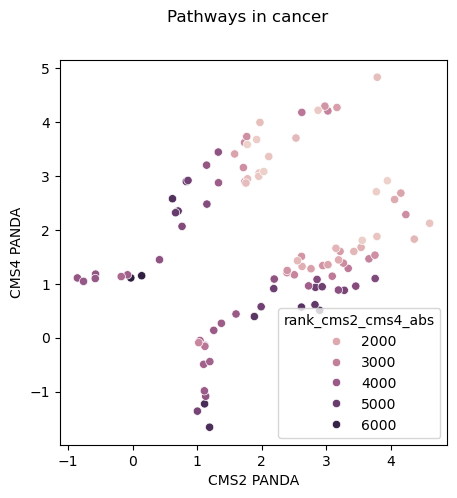

In [ ]:
# Plot relatiionship between PANDA cms2 and cms4 values
f,ax = plt.subplots(1,figsize = (5,5))
sns.scatterplot(x = 'cms2', y = 'cms4', data = temp[temp.symbol.isin(genes_oi)], hue = 'rank_cms2_cms4_abs')
f.suptitle(pathway)
ax.set_xlabel('CMS2 PANDA')
ax.set_ylabel('CMS4 PANDA')
f.savefig(panda_folder+pathway_prefix+'.pdf')


#### Plot actual PANDA values of targets of interest for the top pathways

In [ ]:
def plot_panda_pathway(res, filtered_panda, output_folder, n_pathways = 2):
    
    for i in range(n_pathways):
        # select which term (0: first, 1: second...)
        row_number = i
        pathway = res.results.sort_values(by = 'Adjusted P-value').iloc[row_number,:].Term
        adjpval =  res.results.sort_values(by = 'Adjusted P-value').iloc[row_number,:]['Adjusted P-value']
        pathway_prefix = '_'.join(pathway.split(' '))
        genes_oi = res.results.sort_values(by = 'Adjusted P-value').iloc[row_number,:].Genes.split(';')

        print("We look now into the %s pathway" %pathway)
        
        # cms2 values
        aaa = pd.pivot_table(filtered_panda[filtered_panda.symbol.isin(genes_oi)], columns = 'symbol', index = 'tf', values = 'cms2')
        # cms4 values
        bbb = pd.pivot_table(filtered_panda[filtered_panda.symbol.isin(genes_oi)], columns = 'symbol', index = 'tf', values = 'cms4')
            
        filtered_panda['edge'] = filtered_panda['tf'] + '-' + filtered_panda['symbol']
        filtered_panda = filtered_panda.sort_values(by = 'tf')
        mydata = (filtered_panda[filtered_panda.symbol.isin(genes_oi)].loc[:,['edge','cms2','cms4']]).set_index('edge').T
        sns.set_context("paper", font_scale=1)
        g1 = sns.clustermap(mydata, cmap = 'coolwarm', center = 1, 
                    xticklabels = True, 
                    row_cluster=False,
                    figsize = (14,4),
                    cbar_pos = (0.02, 0.8, 0.1, 0.1),
                    # add title to cbar and put the name on top of cbar
                    cbar_kws = {'label': 'PANDA value', 'orientation': 'horizontal'},
                    #
                    dendrogram_ratio=.1
                    )
        # title needs to be above the figure, not overlapped with the dendrogram
        
        # adjust ratio between cbar and plot
        g1.cax.set_position([.05, .8, .05, .2])                   
        
        g1.fig.suptitle('%s: %s (%s)' %(cluster_name, pathway, str('FDR = %.3f' %adjpval)), y=1.05)
        
        #g1.fig.suptitle('%s: %s (%s)' %(cluster_name, pathway, str('FDR = %.3f' %adjpval)))
        g1.fig.savefig(panda_folder+cluster_name + '_'+pathway_prefix+'.pdf', bbox_inches = 'tight')
        


We look now into the Pathways in cancer pathway
We look now into the Transcriptional misregulation in cancer pathway
We look now into the Linoleic acid metabolism pathway
We look now into the Fatty acid biosynthesis pathway
We look now into the PPAR signaling pathway pathway


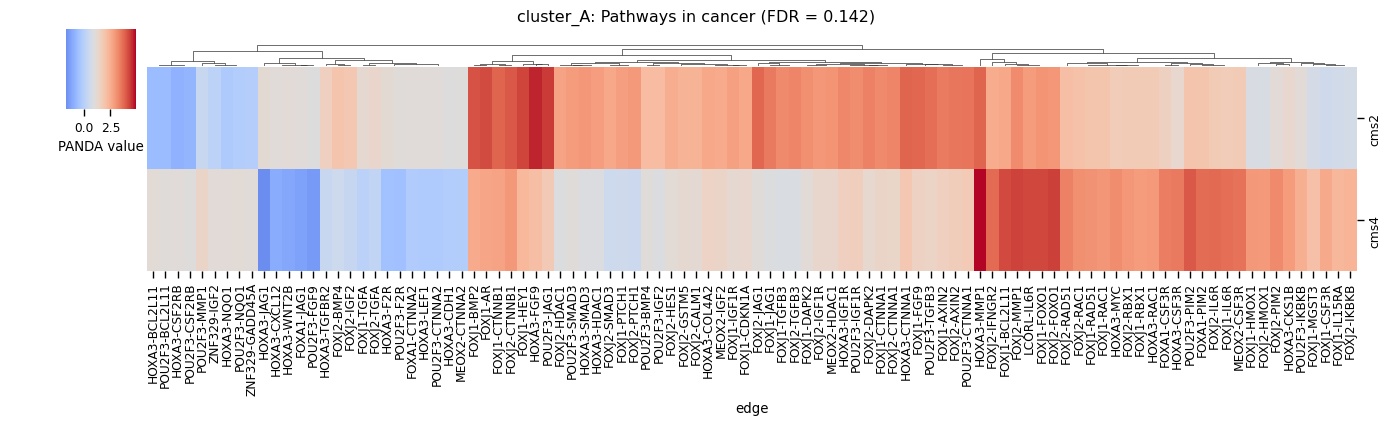

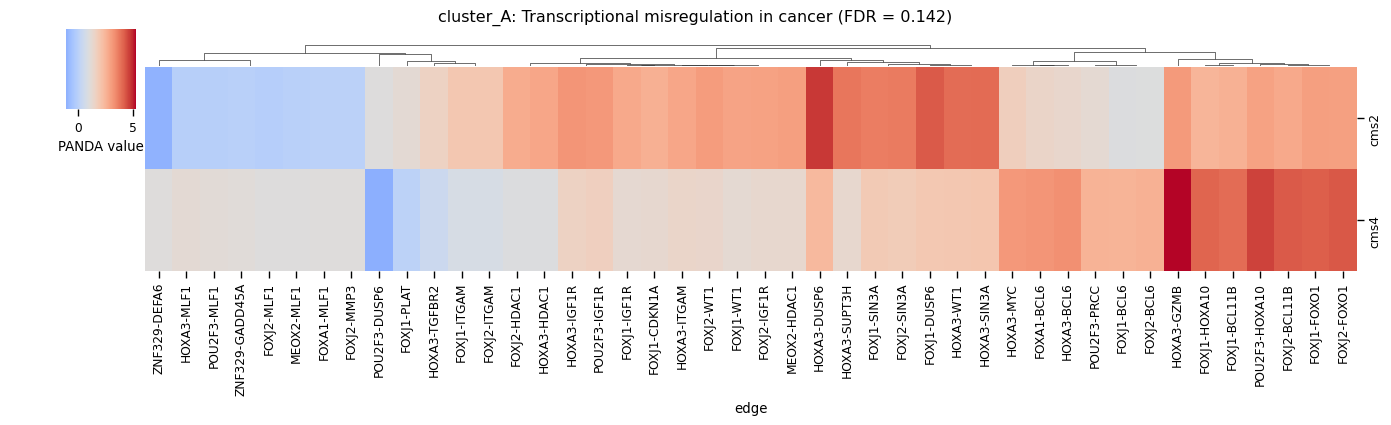

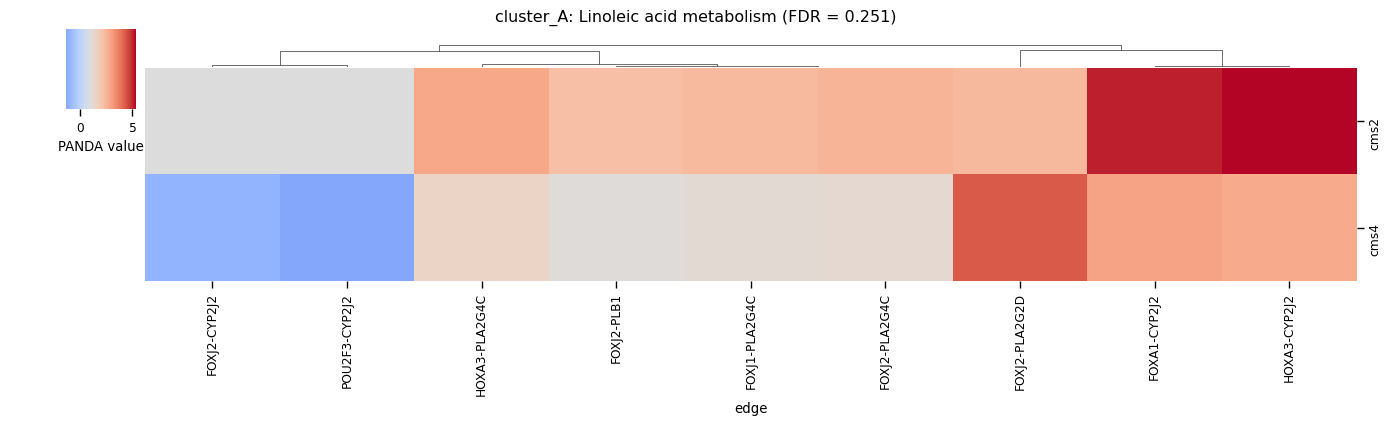

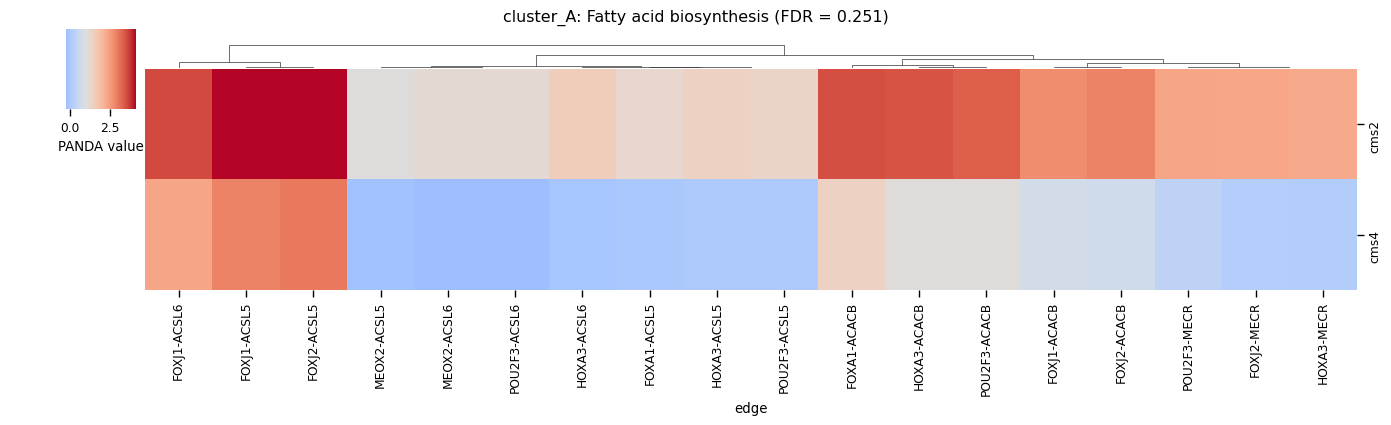

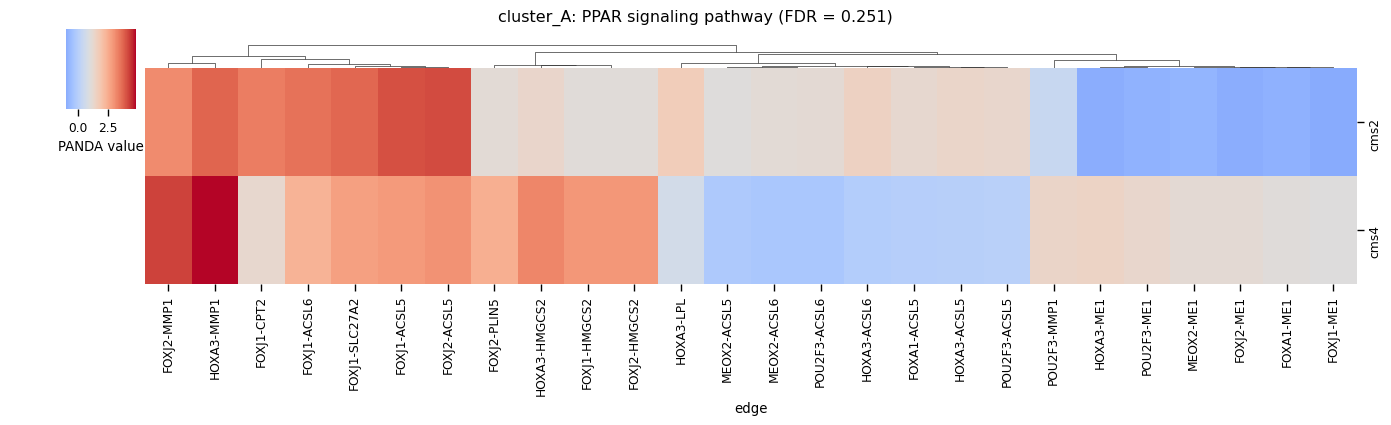

In [ ]:
plot_panda_pathway(res, temp, output_folder=output_folder, n_pathways = 5)